In [1]:
%load_ext autoreload
%autoreload 2
import jax
import optax
import jax.numpy as jnp
from jax import jit
from jax import random
from jax.random import PRNGKey, split
from jax.experimental.ode import odeint
from jax import vmap
# import seaborn as sns
from matplotlib import pyplot as plt
from typing import Sequence
from functools import partial
import numpy as onp
from flax import linen as nn
from flax import serialization
from dataclasses import field, dataclass
from flax_transformer import TransformerConfig, TransformerGaussianMixturePosterior, generative_model

DeviceArray(190, dtype=int32)

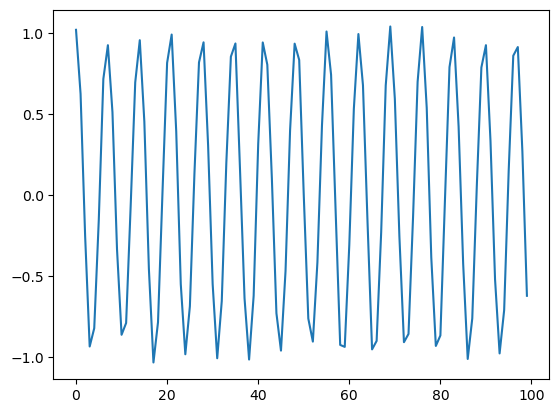

In [2]:
key, *subkeys = random.split(random.PRNGKey(0), 4)
q, latents = generative_model(subkeys[2], 1000, 100)
num = 190
plt.plot(q[num])
cs = latents[:,0,1]/latents[:,0,0]
jnp.argmax(cs)

In [3]:
def gaussian_mixture_logpdf(latents, dist_params):
    mix_p, means, covs = dist_params['mix_p'], dist_params['means'], dist_params['covariance_matrices']
    
    normals_log_prob = jax.scipy.stats.multivariate_normal.logpdf(latents, means, covs)
    category_log_prob = jax.lax.log(mix_p)
    
    return jax.nn.logsumexp(normals_log_prob + category_log_prob, axis=1)


def update_step(apply_fn, q, latents, opt_state, params, state, dropout_key):
    def loss(params):
        d_params = apply_fn({'params':params, **state},
                                    q, rngs={'dropout': dropout_key})
        l = -gaussian_mixture_logpdf(latents, d_params).mean()
        return l
    
    l, grads = jax.value_and_grad(loss, has_aux=False)(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params, l

In [5]:
%%time
key, *subkeys = split(PRNGKey(11234), 4)
m = TransformerGaussianMixturePosterior(TransformerConfig())
batch_size = 4000
obs_lenght= 100
init_rngs = {'params': subkeys[0], 'dropout':subkeys[1]}
variables = m.init(init_rngs, jnp.ones((batch_size, obs_lenght, 1)))
state, params = variables.pop('params')
del variables
tx = optax.adam(learning_rate=0.001)
opt_state = tx.init(params)

total_data_size = int(3e6)
num_epochs = 50*12*6
finish = False
params_checkpoints = {}
save_params = 50
# def train(key, params, state, tx, opt_state, num_epochs, total_data_size):
for e in range(num_epochs):
    # with open('checkpoint-1826pm', 'rb') as f:
    #     (key, params, opt_state) = serialization.from_bytes((key, params, opt_state), f.read())
    key, subkey = split(key)
    q, latents = jax.tree_map(onp.array, generative_model(subkey, total_data_size, obs_lenght))
    for i in range(total_data_size//batch_size):
        if (i+1) % save_params == 0:
            params_checkpoints[f'opt_state_{e}_{i}'] = jax.tree_map(onp.array,opt_state)
            params_checkpoints[f'params_{e}_{i}'] = jax.tree_map(onp.array,params)
            params_checkpoints[f'key_{e}_{i}'] = jax.tree_map(onp.array,key)
        key, subkey = split(key)
        opt_state, params, l = jit(update_step, static_argnums=(0,))(
        # opt_state, params, l = update_step(
            m.apply, 
            jnp.array(q[i*batch_size: (i+1)*batch_size]), 
            jnp.array(latents[i*batch_size: (i+1)*batch_size]),
            opt_state, params, state, subkey)
        if i % 100 == 0:      
            print(e,i,l)
        if jnp.isnan(l) or l == 0:
            print('failed',e,i,l)
            finish = True
            break
    if finish:
        break
    #             return old_params
    # return params


0 0 17.46609
0 100 2.804739
0 200 3.9741778
0 300 3.112016
0 400 1.5672208
0 500 1.3355281
0 600 1.3025684
0 700 0.92371535
1 0 0.6398308
1 100 0.46490243
1 200 0.33353055
1 300 0.23269099
1 400 0.36182204
1 500 0.05417461
1 600 0.18449506
1 700 0.014443637
2 0 0.0059121926
2 100 0.32891998
2 200 -0.039710756
2 300 0.34018335
2 400 -0.043548115
2 500 -0.05833694
2 600 -0.08745991
2 700 -0.078422725
3 0 -0.09814049
3 100 -0.028010825
3 200 -0.10630115
3 300 -0.12145901
3 400 -0.06971245
3 500 -0.112182505
3 600 -0.02756942
3 700 -0.101983905
4 0 -0.09922795
4 100 -0.14828272
4 200 -0.12166678
4 300 -0.19859761
4 400 -0.15636499
4 500 -0.10965364
4 600 -0.16294296
4 700 -0.13681246
5 0 -0.13372678
5 100 -0.08385221
5 200 -0.15059021
5 300 -0.15083909
5 400 -0.1857748
5 500 -0.08892626
5 600 -0.13987851
5 700 -0.039053835
6 0 -0.15850675
6 100 -0.09830729
6 200 -0.15214701
6 300 -0.15254025
6 400 -0.096518256
6 500 -0.16309848
6 600 -0.17968135
6 700 -0.18028556
7 0 -0.1861609
7 100 -0.16

In [ ]:
params_checkpoints.keys()
# key, params, opt_state = params_checkpoints['key_0_69'],params_checkpoints['params_0_69'],params_checkpoints['opt_state_0_69']
# from flax import serialization
# with open('all_params','wb') as f:
#     f.write(serialization.to_bytes(params_checkpoints))
# with open('checkpoint_09-04', 'rb') as f:
#     (key, params, opt_state) = serialization.from_bytes((key, params, opt_state), f.read())
# # if '':
# #     print('hi')

In [8]:
params = jax.tree_map(jnp.array, params_checkpoints['params_58_599'])
opt_state = jax.tree_map(jnp.array, params_checkpoints['opt_state_58_599'])

In [9]:
m = TransformerGaussianMixturePosterior(TransformerConfig(deterministic=True))
variables = m.init({'params': subkeys[0]}, jnp.ones((batch_size, 100, 1)))
state, _ = variables.pop('params')

In [10]:
from flax_transformer import gaussian_mixture_logpdf
from matplotlib import pyplot as plt
sample_num = 211
dist_params = m.apply({'params':params, **state}, q[:batch_size])
sample_dist_params = jax.tree_map(lambda x: x[sample_num][None], dist_params)
def my_plot(sample_dist_params, latents, ax, sample_num):
    x = jnp.linspace(-0.1,1.1)
    y = jnp.linspace(-0.1,10.5)
    X,Y = jnp.meshgrid(x,y)
    XX = jnp.array([X.ravel(), Y.ravel()]).T
    Z = jax.lax.exp(gaussian_mixture_logpdf(XX[:,None],sample_dist_params))
    Z = Z.reshape(X.shape)
    ax.contour(X,Y,Z,)
    ax.scatter(latents[sample_num,0,0], latents[sample_num,0,1])
    ax.axline((0,0),slope = latents[sample_num,0,1]/latents[sample_num,0,0])

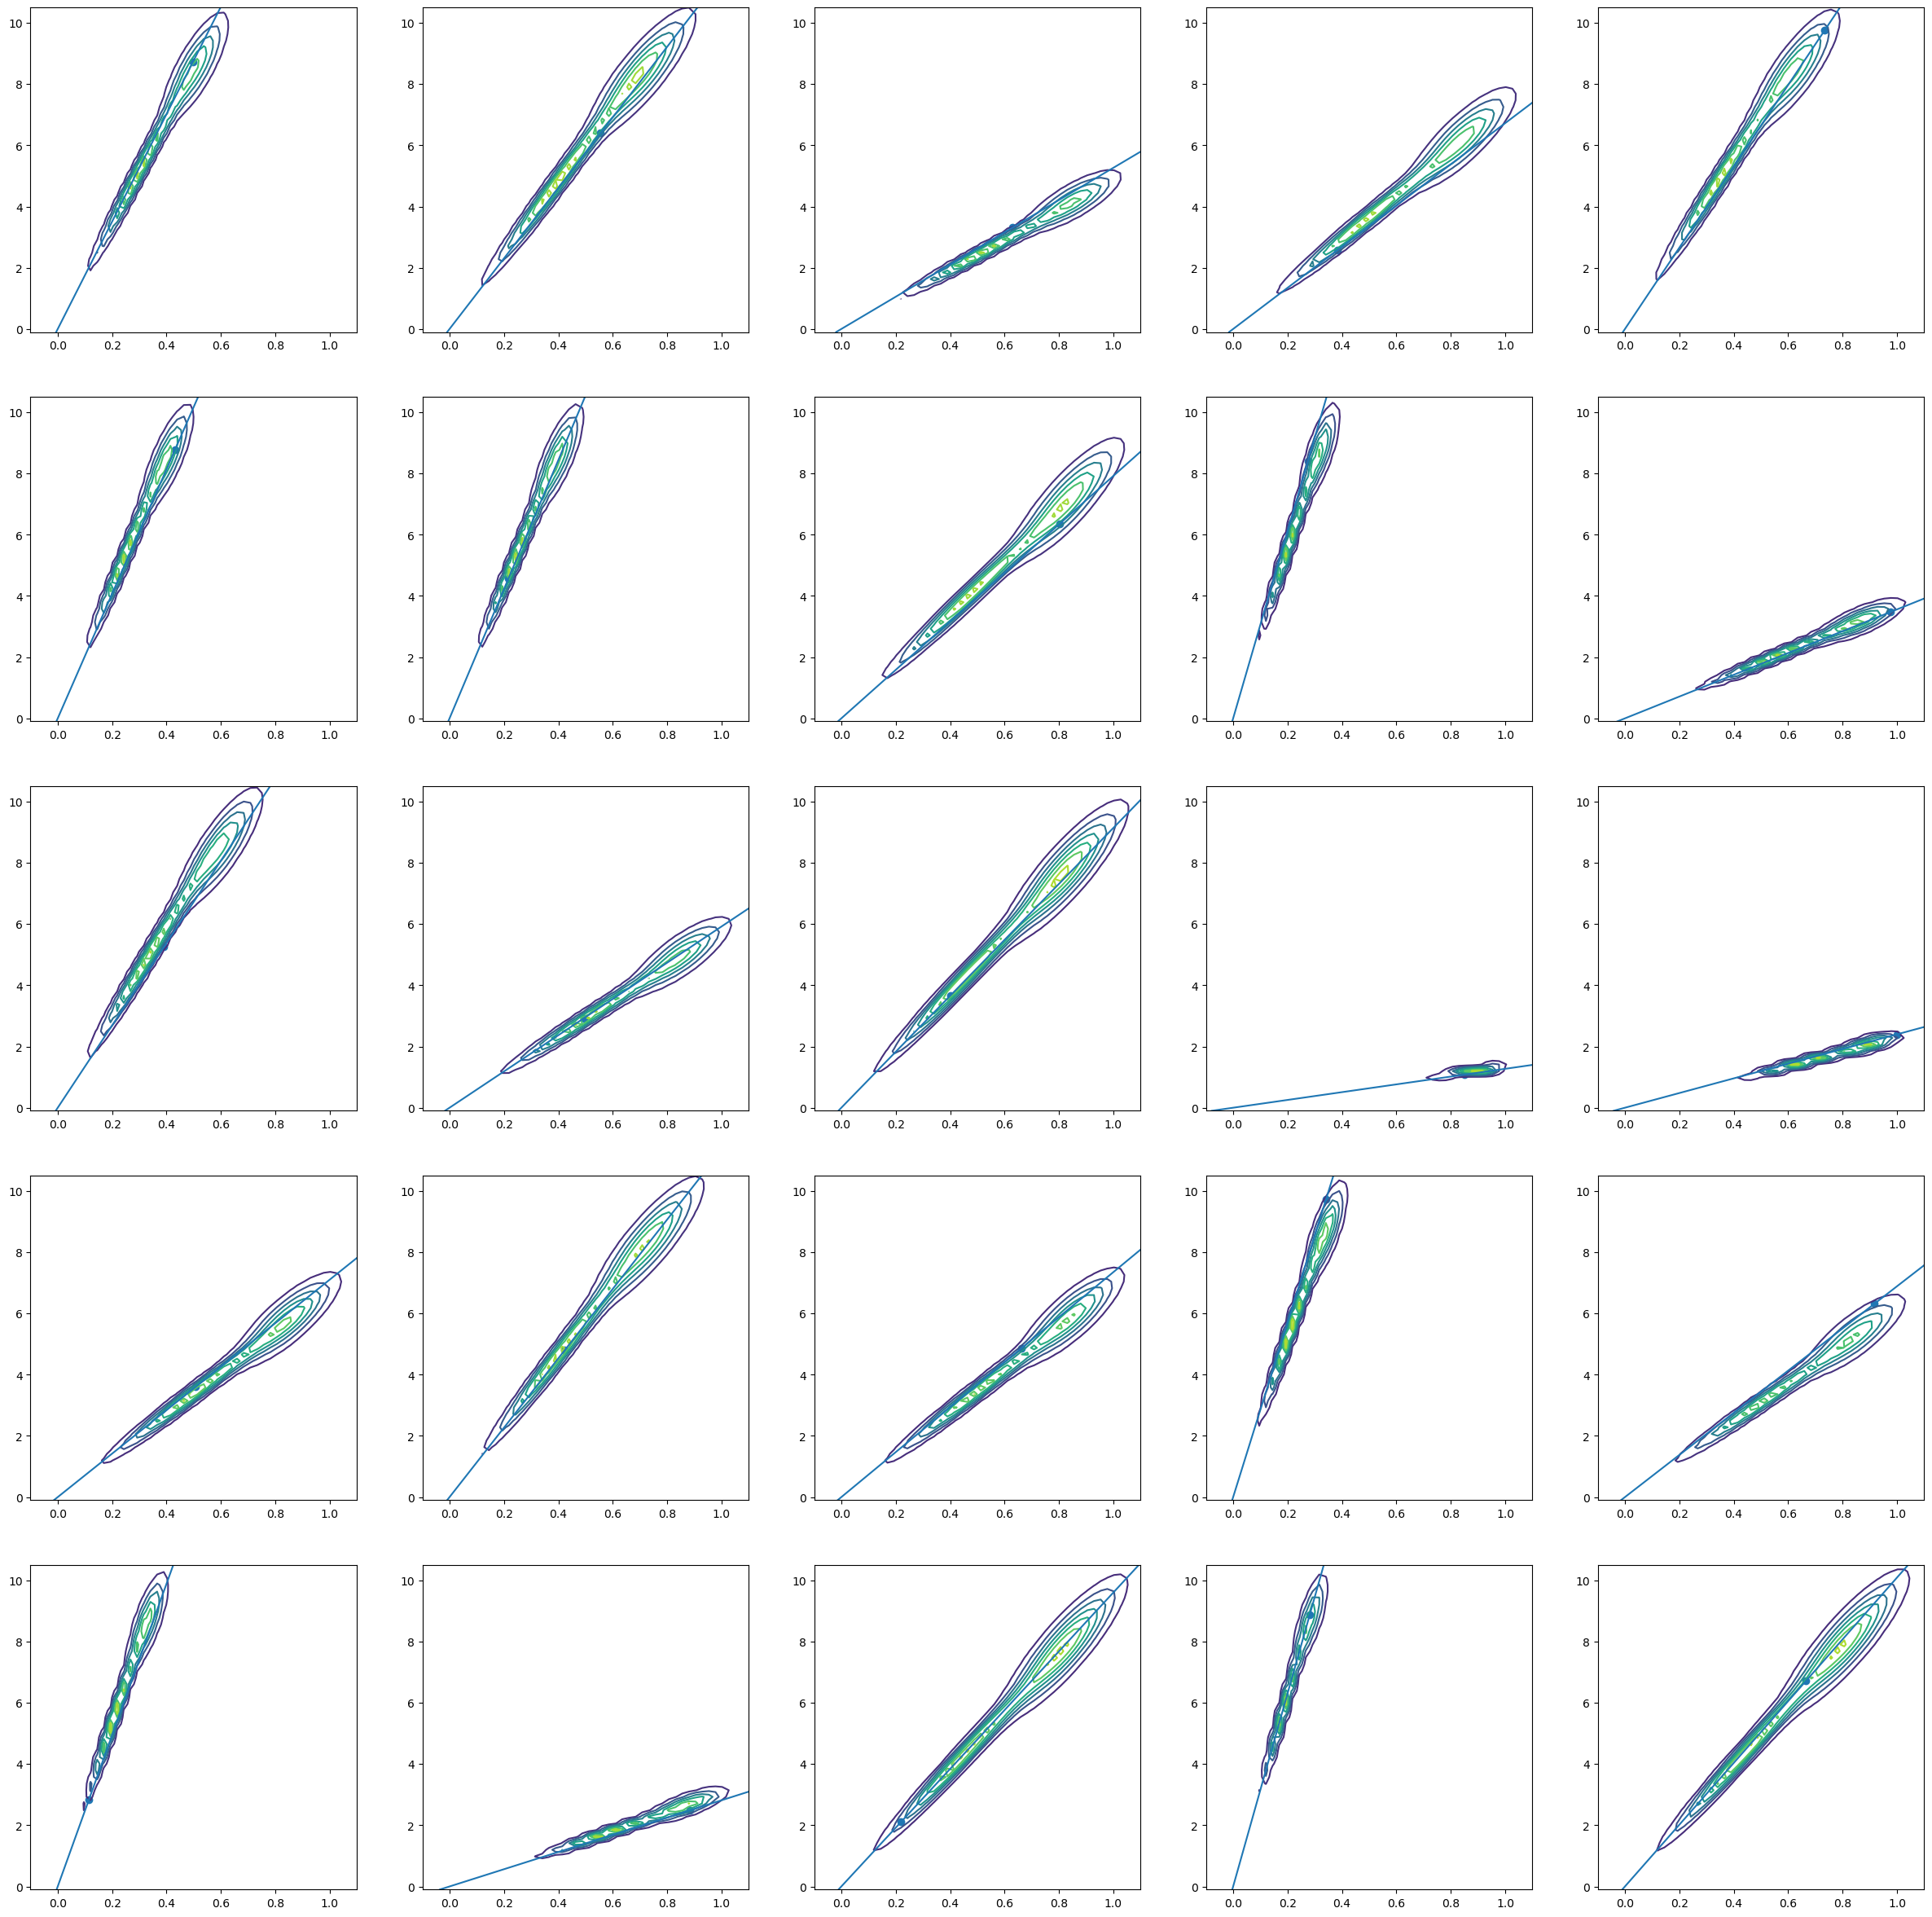

In [11]:
import math

num_plots = 25
num_cols = 5
num_rows = math.ceil(num_plots/num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30,30))
dist_params = m.apply({'params':params, **state}, q[:1000])
for i in range(num_plots):
    sample_num = onp.random.randint(0, 1000)
    sample_dist_params = jax.tree_map(lambda x: x[sample_num][None], dist_params)
    
    c = i % num_cols
    r = math.floor(i/num_cols)
    my_plot(sample_dist_params, latents, axes[r,c], sample_num)
    # sns.kdeplot(u.NormalMixture1D(mixture_probs=dist.mixture_probs[0], 
    #                                means=dist.normals.loc[0], 
    #                                stds=dist.normals.scale[0]).sample(1000).to('cpu'),
    #             ax=axes[r,c])
    # axes[r,c].axvline(theta[0].to('cpu').item(), color='red')

In [31]:
def plot_gaussian(dist_params):
    x = jnp.linspace(-0.1,1.1)
    y = jnp.linspace(-0.1,1.1)
    X,Y = jnp.meshgrid(x,y)
    XX = jnp.array([X.ravel(), Y.ravel()]).T
    Z = jax.lax.exp(gaussian_mixture_logpdf(XX[:,None],test_sample))
    Z = Z.reshape(X.shape)
    plt.contour(X,Y,Z,)

def rotation_matrix(theta):
    return jnp.array([[jnp.cos(theta), -jnp.sin(theta)],[jnp.sin(theta), jnp.cos(theta)]])

In [104]:
test_sample = jax.tree_map(lambda x: x[:,:2], sample_dist_params)
my_covariance = jnp.array([[[[0.1, 0.3],[0.3, 1.0]]]]) 
# rot_matrix = rotation_matrix(-jnp.pi/4*0)
# test_sample['covariance_matrices'] = jnp.einsum('...ij,jk -> ...ik', my_covariance, rot_matrix)

# test_sample['covariance_matrices'] = 
plot_gaussian(test_sample)
test_sample['covariance_matrices'], onp.linalg.det(test_sample['covariance_matrices'][0,0])

NameError: name 'plot_gaussian' is not defined

In [18]:
def depends_on_value(x):
    if x % 2 == 0:
        return x ** 2
    else:
        return x-1

jax.make_jaxpr(jax.jit(lambda: depends_on_value(2)))()

{ lambda ; . let
    a:i32[] = xla_call[call_jaxpr={ lambda ; . let  in (4,) } name=<lambda>] 
  in (a,) }